In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score,roc_curve, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Dense, Embedding, LSTM
from keras.utils import to_categorical

from IPython.display import display
import random
import matplotlib.pyplot as plt
# random.seed(10)

In [2]:
# Import Data
games_folder_path = "C:/Users/Craig/Documents/Thesis/Thomas_Gallagher_Thesis/Data/AFL_Stats_sorted/Year/Games/"
games_2012 = pd.read_csv(games_folder_path + '2012.csv', index_col=False, parse_dates=['date'])
games_2013 = pd.read_csv(games_folder_path + '2013.csv', index_col=False, parse_dates=['date'])
games_2014 = pd.read_csv(games_folder_path + '2014.csv', index_col=False, parse_dates=['date'])
games_2015 = pd.read_csv(games_folder_path + '2015.csv', index_col=False, parse_dates=['date'])
games_2016 = pd.read_csv(games_folder_path + '2016.csv', index_col=False, parse_dates=['date'])
games_2017 = pd.read_csv(games_folder_path + '2017.csv', index_col=False, parse_dates=['date'])
games_2018 = pd.read_csv(games_folder_path + '2018.csv', index_col=False, parse_dates=['date'])
games_2019 = pd.read_csv(games_folder_path + '2019.csv', index_col=False, parse_dates=['date'])
games_2020 = pd.read_csv(games_folder_path + '2020.csv', index_col=False, parse_dates=['date'])
games_2021 = pd.read_csv(games_folder_path + '2021.csv', index_col=False, parse_dates=['date'])


all_games = pd.read_csv(games_folder_path + 'games_sorted.csv', index_col=False, parse_dates=['date'])

C:\Users\Craig\AppData\Local\Temp\ipykernel_17608\3458396436.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  games_2012 = pd.read_csv(games_folder_path + '2012.csv', index_col=False, parse_dates=['date'])
C:\Users\Craig\AppData\Local\Temp\ipykernel_17608\3458396436.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  games_2013 = pd.read_csv(games_folder_path + '2013.csv', index_col=False, parse_dates=['date'])
C:\Users\Craig\AppData\Local\Temp\ipykernel_17608\3458396436.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  games_2014 = pd.read_csv(games_

In [3]:
# One Hot Encoding Teams
encoding = LabelEncoder()
encoding.fit(all_games["homeTeam"].values)


def OHE_Teams(games):
    home_teams = encoding.transform(games["homeTeam"].values)
    away_teams = encoding.transform(games["awayTeam"].values)

    all_teams = np.vstack([home_teams, away_teams]).T
 
    oneHot = OneHotEncoder()
    X_teams = oneHot.fit_transform(all_teams).todense()
    X_teams = pd.DataFrame(X_teams)
    games = pd.concat([games, pd.DataFrame(X_teams)],axis=1)
    return games

games_2012 = OHE_Teams(games_2012)
games_2013 = OHE_Teams(games_2013)
games_2014 = OHE_Teams(games_2014)
games_2015 = OHE_Teams(games_2015)
games_2016 = OHE_Teams(games_2016)
games_2017 = OHE_Teams(games_2017)
games_2018 = OHE_Teams(games_2018)
games_2019 = OHE_Teams(games_2019)
games_2020 = OHE_Teams(games_2020)
games_2021 = OHE_Teams(games_2021)

all_games = OHE_Teams(all_games)

In [4]:
# One Hot Encoding Venues
encoding = LabelEncoder()
encoding.fit(all_games["venue"].values)
all_venues = all_games["venue"].values

all_venues = all_venues.reshape(-1,1)

def OHE_Venues(games):
    venues = games['venue'].values
    # all_venues = all_venues.reshape(-1,1)
    venues = venues.reshape(-1,1)
    oneHot = OneHotEncoder()

    oneHot.fit(all_venues)
    X_venues = oneHot.transform(venues).toarray()
    X_venues = pd.DataFrame(X_venues, columns=oneHot.categories_[0])
    games = pd.concat([games, X_venues], axis=1)
    return games

games_2012 = OHE_Venues(games_2012)
games_2013 = OHE_Venues(games_2013)
games_2014 = OHE_Venues(games_2014)
games_2015 = OHE_Venues(games_2015)
games_2016 = OHE_Venues(games_2016)
games_2017 = OHE_Venues(games_2017)
games_2018 = OHE_Venues(games_2018)
games_2019 = OHE_Venues(games_2019)
games_2020 = OHE_Venues(games_2020)
games_2021 = OHE_Venues(games_2021)

all_games = OHE_Venues(all_games)

In [5]:
def split_time(row):
    time = row['startTime']
    time = time.split(':')
    time = ''.join(time[:2])
    row['startTime'] = time
    return row

games_2012 = games_2012.apply(split_time, axis=1)
games_2013 = games_2013.apply(split_time, axis=1)
games_2014 = games_2014.apply(split_time, axis=1)
games_2015 = games_2015.apply(split_time, axis=1)
games_2016 = games_2016.apply(split_time, axis=1)
games_2017 = games_2017.apply(split_time, axis=1)
games_2018 = games_2018.apply(split_time, axis=1)
games_2019 = games_2019.apply(split_time, axis=1)
games_2020 = games_2020.apply(split_time, axis=1)
games_2021 = games_2021.apply(split_time, axis=1)

In [6]:
y_true_2012 = games_2012['homeWin']
y_true_2013 = games_2013['homeWin']
y_true_2014 = games_2014['homeWin']
y_true_2015 = games_2015['homeWin']
y_true_2016 = games_2016['homeWin']
y_true_2017 = games_2017['homeWin']
y_true_2018 = games_2018['homeWin']
y_true_2019 = games_2019['homeWin']
y_true_2020 = games_2020['homeWin']
y_true_2021 = games_2021['homeWin']
y_true = all_games['homeWin']

drop_values = ['gameId', 'venue', 'homeWin', 'homeTeam', 'awayTeam', 'year','date', 'homeTeamScore', 'awayTeamScore', 'round']

def drop_columns(game_list):
    game_list = game_list.drop(drop_values,axis=1)
    game_list.columns = game_list.columns.astype(str)
    return game_list

games_2012 = drop_columns(games_2012)
games_2013 = drop_columns(games_2013)
games_2014 = drop_columns(games_2014)
games_2015 = drop_columns(games_2015)
games_2016 = drop_columns(games_2016)
games_2017 = drop_columns(games_2017)
games_2018 = drop_columns(games_2018)
games_2019 = drop_columns(games_2019)
games_2020 = drop_columns(games_2020)
games_2021 = drop_columns(games_2021)

all_games = drop_columns(all_games)

In [7]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
games_2012 = scaler.fit_transform(games_2012)
games_2013 = scaler.fit_transform(games_2013)
games_2014 = scaler.fit_transform(games_2014)
games_2015 = scaler.fit_transform(games_2015)
games_2016 = scaler.fit_transform(games_2016)
games_2017 = scaler.fit_transform(games_2017)
games_2018 = scaler.fit_transform(games_2018)
games_2019 = scaler.fit_transform(games_2019)
games_2020 = scaler.fit_transform(games_2020)
games_2021 = scaler.fit_transform(games_2021)

# all_games = scaler.fit_transform(all_games)

In [8]:
y_train_2012 = y_true_2012[18:171]
y_valid_2012 = y_true_2012[171:]

y_train_2013 = y_true_2013[18:171]
y_valid_2013 = y_true_2013[171:]

y_train_2014 = y_true_2014[18:171]
y_valid_2014 = y_true_2014[171:]

y_train_2015 = y_true_2015[18:170]
y_valid_2015 = y_true_2015[170:]

y_train_2016 = y_true_2016[18:171]
y_valid_2016 = y_true_2016[171:]

y_train_2017 = y_true_2017[18:171]
y_valid_2017 = y_true_2017[171:]

y_train_2018 = y_true_2018[18:171]
y_valid_2018 = y_true_2018[171:]

y_train_2019 = y_true_2019[18:171]
y_valid_2019 = y_true_2019[171:]

y_train_2020 = y_true_2020[18:127]
y_valid_2020 = y_true_2020[127:]

y_train_2021 = y_true_2021[18:171]
y_valid_2021 = y_true_2021[171:]

y_train = y_true[:1447]
y_valid = y_true[1447:1655]

In [9]:
# OHE Y values
oneHot = OneHotEncoder()
def OHE_y_values(y_val):
    y = np.vstack([y_val]).T
    
    # for i in range(len(y)):
    #     if y[i] == 1:
    #         y[i] = 0

    y_OHE = oneHot.fit_transform(y).toarray()

    return y_OHE


y_train_2012_OHE = OHE_y_values(y_train_2012)
y_valid_2012_OHE = OHE_y_values(y_valid_2012)

y_train_2013_OHE = OHE_y_values(y_train_2013)
y_valid_2013_OHE = OHE_y_values(y_valid_2013)

y_train_2014_OHE = OHE_y_values(y_train_2014)
y_valid_2014_OHE = OHE_y_values(y_valid_2014)

y_train_2015_OHE = OHE_y_values(y_train_2015)
y_valid_2015_OHE = OHE_y_values(y_valid_2015)

y_train_2016_OHE = OHE_y_values(y_train_2016)
y_valid_2016_OHE = OHE_y_values(y_valid_2016)

y_train_2017_OHE = OHE_y_values(y_train_2017)
y_valid_2017_OHE = OHE_y_values(y_valid_2017)

y_train_2018_OHE = OHE_y_values(y_train_2018)
y_valid_2018_OHE = OHE_y_values(y_valid_2018)

y_train_2019_OHE = OHE_y_values(y_train_2019)
y_valid_2019_OHE = OHE_y_values(y_valid_2019)

y_train_2020_OHE = OHE_y_values(y_train_2020)
y_valid_2020_OHE = OHE_y_values(y_valid_2020)

y_train_2021_OHE = OHE_y_values(y_train_2021)
y_valid_2021_OHE = OHE_y_values(y_valid_2021)

y_train_OHE = OHE_y_values(y_train)
y_valid_OHE = OHE_y_values(y_valid)

In [10]:
def set_window(games):
    y = 0 #
    p = 0 # round 0
    # d_full = np.zeros(shape=(1980,75))
    d_full = np.zeros(shape=(3591,92)) # (207 - 18) * 18 + (207 - 18)
    for x in range(0,d_full.shape[0],19): # For games in each round corresponds to d_full, when a round is ended it jumps over the added games
        y = 18 # link to previous rounds
        if x % 171 == 0: # Games in each round * added games
            p += 1 # move to next round when 90 index is reached
        for i in range(18): # fills out the first 18 posistions in the window with previous games
            d_full[x+i] = games[p+i] # at pos x add corresponding previous game
        d_full[x+y] = games[x//19 + y] # add game in question to final position
    
    d_Train = d_full[:2907]
    d_valid = d_full[2907:]
    d_Train = np.reshape(d_Train, (153, 19,92))
    d_valid = np.reshape(d_valid, (36, 19, 92))
    return d_Train, d_valid

x_train_2012, x_valid_2012 = set_window(games_2012)
x_train_2013, x_valid_2013 = set_window(games_2013)
x_train_2014, x_valid_2014 = set_window(games_2014)
# x_train_2015, x_valid_2015 = set_window(games_2015)
x_train_2016, x_valid_2016 = set_window(games_2016)
x_train_2017, x_valid_2017 = set_window(games_2017)
x_train_2018, x_valid_2018 = set_window(games_2018)
x_train_2019, x_valid_2019 = set_window(games_2019)
# x_train_2020, x_valid_2020 = set_window(games_2020)

In [11]:
def set_window_2015(games):
    y = 0
    p = 0
    d_full = np.zeros(shape=(3572,92))
    for x in range(0,d_full.shape[0],19): # Goes through index for each round
        y = 18 # link to previous round
        if x % 171 == 0:
            p += 1 # move to next round when 90 index is reached
        for i in range(18): # fills out the first nine posistions in the window with previous games
                d_full[x+i] = games[p+i] # at pos x add corresponding previous game
            
        d_full[x+y] = games[x//19 + y] # add game in question to final position
        
    d_Train = d_full[:2888]
    d_valid = d_full[2888:]
    d_Train = np.reshape(d_Train, (152, 19,92))
    d_valid = np.reshape(d_valid, (36, 19, 92))
    return d_Train, d_valid

x_train_2015, x_valid_2015 = set_window_2015(games_2015)


In [40]:
def train_model_5( xTrain, yTrain, xValid , yValid):
    random.seed(26)
    model = Sequential()
    model.add(LSTM( 64 ,input_shape = (19,92), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3))
    model.add(Dense(2, activation="tanh"))
    model.build()   
    model.summary()
    model.compile( optimizer = "rmsprop" , loss = 'mean_squared_error' , metrics = ['accuracy', 'mse'])

    reduce_lr = ReduceLROnPlateau( monitor = 'accuracy', factor = 0.01, patience=10, cooldown=0)
    
    callbacks = [ reduce_lr ]
    model.fit( xTrain, yTrain , epochs = 50, shuffle=False, callbacks=callbacks, verbose = 2)

    # train_history = model.fit( x_train_2012 , y_train_2012 , epochs = 10, validation_split = 0.1 , verbose = 1 )
    score = model.evaluate( xValid , yValid )
    pred = model.predict(xValid)
    model.save("LSTM_5")
    # print( f"Train Accuracy: {train_history.history}" )
    
    print( "Accuracy: {:0.4}".format( score[1] ))
    print( "Loss:", score[0] )
    return score, pred


In [44]:
results_2012, pred_2012 = train_model_5(x_train_2012, y_train_2012_OHE, x_valid_2012, y_valid_2012_OHE) 
results_2013, pred_2013 = train_model_5(x_train_2013, y_train_2013_OHE, x_valid_2013, y_valid_2013_OHE) 
results_2014, pred_2014 = train_model_5(x_train_2014, y_train_2014_OHE, x_valid_2014, y_valid_2014_OHE) 
results_2015, pred_2015 = train_model_5(x_train_2015, y_train_2015_OHE, x_valid_2015, y_valid_2015_OHE) 
results_2016, pred_2016 = train_model_5(x_train_2016, y_train_2016_OHE, x_valid_2016, y_valid_2016_OHE) 
results_2017, pred_2017 = train_model_5(x_train_2017, y_train_2017_OHE, x_valid_2017, y_valid_2017_OHE) 
results_2018, pred_2018 = train_model_5(x_train_2018, y_train_2018_OHE, x_valid_2018, y_valid_2018_OHE) 
results_2019, pred_2019 = train_model_5(x_train_2019, y_train_2019_OHE, x_valid_2019, y_valid_2019_OHE)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                40192     
                                                                 
 dense_16 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.3108 - accuracy: 0.4575 - mse: 0.3108 - lr: 0.0010 - 3s/epoch - 658ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2624 - accuracy: 0.4706 - mse: 0.2624 - lr: 0.0010 - 84ms/epoch - 17ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2548 - accuracy: 0.5229 - mse: 0.2548 - lr: 0.0010 - 87ms/epoch - 17ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2530 - accuracy: 0.4771 - mse: 0.2530 - lr: 0.0010 - 94ms/epoch - 19ms/step
Epoch 5/50
5/5 - 0s - 

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.6111
Loss: 0.22089028358459473
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 64)                40192     
                                                                 
 dense_17 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.2865 - accuracy: 0.5425 - mse: 0.2865 - lr: 0.0010 - 3s/epoch - 619ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2506 - accuracy: 0.5294 - mse: 0.2506 - lr: 0.0010 - 100ms/epoch - 20ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2414 - accuracy: 0.5752 - mse: 0.2414 - lr: 0.0010 - 101ms/epoch - 20ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2322 - accuracy: 0.5621 - mse: 0.2322 - lr: 0.0010 - 

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.7222
Loss: 0.20423926413059235
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 64)                40192     
                                                                 
 dense_18 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.2812 - accuracy: 0.5817 - mse: 0.2812 - lr: 0.0010 - 3s/epoch - 623ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2391 - accuracy: 0.6078 - mse: 0.2391 - lr: 0.0010 - 87ms/epoch - 17ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2366 - accuracy: 0.6078 - mse: 0.2366 - lr: 0.0010 - 83ms/epoch - 17ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2334 - accuracy: 0.6601 - mse: 0.2334 - lr: 0.0010 - 91

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.6944
Loss: 0.2176419496536255
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 64)                40192     
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.3233 - accuracy: 0.4671 - mse: 0.3233 - lr: 0.0010 - 3s/epoch - 616ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2610 - accuracy: 0.4934 - mse: 0.2610 - lr: 0.0010 - 100ms/epoch - 20ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2521 - accuracy: 0.5658 - mse: 0.2521 - lr: 0.0010 - 102ms/epoch - 20ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2470 - accuracy: 0.5855 - mse: 0.2470 - lr: 0.0010 - 8

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.5833
Loss: 0.20972923934459686
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                40192     
                                                                 
 dense_20 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.2796 - accuracy: 0.6209 - mse: 0.2796 - lr: 0.0010 - 3s/epoch - 630ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2326 - accuracy: 0.6144 - mse: 0.2326 - lr: 0.0010 - 83ms/epoch - 17ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2365 - accuracy: 0.6340 - mse: 0.2365 - lr: 0.0010 - 83ms/epoch - 17ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2261 - accuracy: 0.6471 - mse: 0.2261 - lr: 0.0010 - 96

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.5556
Loss: 0.2486078441143036
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 64)                40192     
                                                                 
 dense_21 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.3007 - accuracy: 0.4967 - mse: 0.3007 - lr: 0.0010 - 3s/epoch - 643ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2540 - accuracy: 0.5425 - mse: 0.2540 - lr: 0.0010 - 101ms/epoch - 20ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2523 - accuracy: 0.5490 - mse: 0.2523 - lr: 0.0010 - 97ms/epoch - 19ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2500 - accuracy: 0.5425 - mse: 0.2500 - lr: 0.0010 - 85

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.75
Loss: 0.21020549535751343
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 64)                40192     
                                                                 
 dense_22 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.2895 - accuracy: 0.5294 - mse: 0.2895 - lr: 0.0010 - 3s/epoch - 618ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2421 - accuracy: 0.5948 - mse: 0.2421 - lr: 0.0010 - 80ms/epoch - 16ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2440 - accuracy: 0.5621 - mse: 0.2440 - lr: 0.0010 - 78ms/epoch - 16ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2310 - accuracy: 0.6209 - mse: 0.2310 - lr: 0.0010 - 87ms

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.6667
Loss: 0.19593846797943115
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 64)                40192     
                                                                 
 dense_23 (Dense)            (None, 2)                 130       
                                                                 
Total params: 40,322
Trainable params: 40,322
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 3s - loss: 0.2994 - accuracy: 0.5294 - mse: 0.2994 - lr: 0.0010 - 3s/epoch - 618ms/step
Epoch 2/50
5/5 - 0s - loss: 0.2550 - accuracy: 0.5294 - mse: 0.2550 - lr: 0.0010 - 104ms/epoch - 21ms/step
Epoch 3/50
5/5 - 0s - loss: 0.2529 - accuracy: 0.5490 - mse: 0.2529 - lr: 0.0010 - 102ms/epoch - 20ms/step
Epoch 4/50
5/5 - 0s - loss: 0.2469 - accuracy: 0.5882 - mse: 0.2469 - lr: 0.0010 - 

INFO:tensorflow:Assets written to: LSTM_5\assets


INFO:tensorflow:Assets written to: LSTM_5\assets


Accuracy: 0.7222
Loss: 0.23345300555229187


In [45]:
results = pd.DataFrame(data = [results_2012[:2],results_2013[:2],results_2014[:2],results_2015[:2],results_2016[:2],
                               results_2017[:2],results_2018[:2],results_2019[:2]],
                            index = ['2012', '2013', '2014','2015','2016','2017','2018','2019'],
                            columns = ['loss', 'accuracy'])
sum(results['accuracy'])/8


0.663194440305233

(Text(0.5, 1.0, '2018'), Text(0.5, 1.0, '2019'))

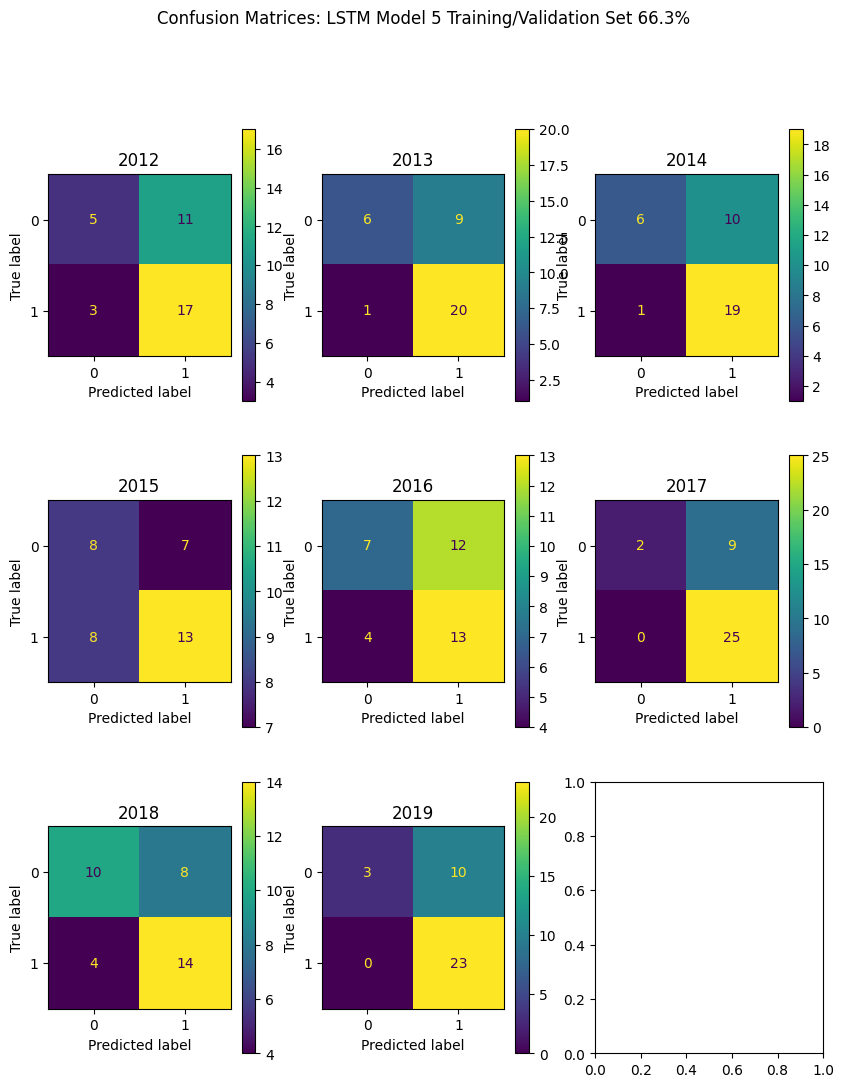

In [47]:
def build_conf_matrix(prediction, true):
    s = 0
    pl = []
    for pred in prediction:
        if pred[0] > pred[1]:
            pl.append(0)
        else:
            pl.append(1)

    for i in range(len(pl)):
        if pl[i] == true.values[i]:
            s+=1

    c_train = confusion_matrix(true, pl)
    disp = ConfusionMatrixDisplay(c_train)
    return disp

cf_2012 = build_conf_matrix(pred_2012, y_valid_2012)
cf_2013 = build_conf_matrix(pred_2013, y_valid_2013)
cf_2014 = build_conf_matrix(pred_2014, y_valid_2014)
cf_2015 = build_conf_matrix(pred_2015, y_valid_2015)
cf_2016 = build_conf_matrix(pred_2016, y_valid_2016)
cf_2017 = build_conf_matrix(pred_2017, y_valid_2017)
cf_2018 = build_conf_matrix(pred_2018, y_valid_2018)
cf_2019 = build_conf_matrix(pred_2019, y_valid_2019)


fig, ax = plt.subplots(3,3)
fig.set_figwidth(10)
fig.set_figheight(12)
fig.suptitle("Confusion Matrices: LSTM Model 5 Training/Validation Set 66.3%")
cf_2012.plot(ax=ax[0][0]), cf_2013.plot(ax=ax[0][1]), cf_2014.plot(ax=ax[0][2])
cf_2015.plot(ax=ax[1][0]), cf_2016.plot(ax=ax[1][1]), cf_2017.plot(ax=ax[1][2])
cf_2018.plot(ax=ax[2][0]), cf_2019.plot(ax=ax[2][1])

ax[0][0].set_title(2012), ax[0][1].set_title(2013), ax[0][2].set_title(2014)
ax[1][0].set_title(2015), ax[1][1].set_title(2016), ax[1][2].set_title(2017)
ax[2][0].set_title(2018), ax[2][1].set_title(2019)

In [13]:
def train_model_5_2( xTrain, yTrain, xValid , yValid):
    random.seed(26)
    model = Sequential()
    model.add(LSTM( 32 ,input_shape = (19,92), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3, return_sequences=True))
    model.add(LSTM(64, dropout=0.3))
    model.add(Dense(32))
    model.add(Dense(2, activation="tanh"))
    model.build()   
    model.summary()
    model.compile( optimizer = "adam" , loss = 'mean_squared_error' , metrics = ['accuracy', 'mse'])

    reduce_lr = ReduceLROnPlateau( monitor = 'accuracy', factor = 0.01, patience=10, cooldown=0)
    
    callbacks = [ reduce_lr ]
    train_history = model.fit( xTrain, yTrain , epochs = 50, shuffle=False, callbacks=callbacks, verbose = 2, validation_split = 0.1)

    score = model.evaluate( xValid , yValid )
    pred = model.predict(xValid)
    model.save("LSTM_1")
    
    print( "Accuracy: {:0.4}".format( score[1] ))
    print( "Loss:", score[0] )
    return score, pred, train_history

results_2012, pred_2012, history_2012 = train_model_5_2(x_train_2012, y_train_2012_OHE, x_valid_2012, y_valid_2012_OHE) 
results_2013, pred_2013, history_2013 = train_model_5_2(x_train_2013, y_train_2013_OHE, x_valid_2013, y_valid_2013_OHE) 
results_2014, pred_2014, history_2014 = train_model_5_2(x_train_2014, y_train_2014_OHE, x_valid_2014, y_valid_2014_OHE) 
results_2015, pred_2015, history_2015 = train_model_5_2(x_train_2015, y_train_2015_OHE, x_valid_2015, y_valid_2015_OHE) 
results_2016, pred_2016, history_2016 = train_model_5_2(x_train_2016, y_train_2016_OHE, x_valid_2016, y_valid_2016_OHE) 
results_2017, pred_2017, history_2017 = train_model_5_2(x_train_2017, y_train_2017_OHE, x_valid_2017, y_valid_2017_OHE) 
results_2018, pred_2018, history_2018 = train_model_5_2(x_train_2018, y_train_2018_OHE, x_valid_2018, y_valid_2018_OHE) 
results_2019, pred_2019, history_2019 = train_model_5_2(x_train_2019, y_train_2019_OHE, x_valid_2019, y_valid_2019_OHE)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 19, 32)            16000     
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 7s - loss: 0.4183 - accuracy: 0.5255 - mse: 0.4183 - val_loss: 0.2471 - val_accuracy: 0.7500 - val_mse: 0.2471 - lr: 0.0010 - 7s/epoch - 1s/step
Epoch 2/50
5/5 - 0s 

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.4444
Loss: 0.2548602819442749
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 19, 32)            16000     
                                                                 
 lstm_5 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 7s - loss: 0.4122 - accuracy: 0.5693 - mse: 0.4122 - val_loss: 0.2811 - val_accuracy: 0.5000 - val_mse: 0.2811 - lr: 0.0010

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.5833
Loss: 0.24595314264297485
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 19, 32)            16000     
                                                                 
 lstm_7 (LSTM)               (None, 64)                24832     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 8s - loss: 0.3933 - accuracy: 0.5693 - mse: 0.3933 - val_loss: 0.2756 - val_accuracy: 0.5625 - val_mse: 0.2756 - lr: 0.001

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.6111
Loss: 0.2259024977684021
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 19, 32)            16000     
                                                                 
 lstm_9 (LSTM)               (None, 64)                24832     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 8s - loss: 0.4176 - accuracy: 0.5000 - mse: 0.4176 - val_loss: 0.2683 - val_accuracy: 0.5625 - val_mse: 0.2683 - lr: 0.0010

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.5833
Loss: 0.24539653956890106
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_11 (LSTM)              (None, 64)                24832     
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 8s - loss: 0.4243 - accuracy: 0.5985 - mse: 0.4243 - val_loss: 0.2414 - val_accuracy: 0.6875 - val_mse: 0.2414 - lr: 0.001

2/2 [==============================] - 1s 7ms/step


INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.4722
Loss: 0.26782897114753723
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_13 (LSTM)              (None, 64)                24832     
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 10s - loss: 0.4135 - accuracy: 0.5620 - mse: 0.4135 - val_loss: 0.2577 - val_accuracy: 0.6250 - val_mse: 0.2577 - lr: 0.00

2/2 [==============================] - 1s 8ms/step


INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.6944
Loss: 0.21510370075702667
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_15 (LSTM)              (None, 64)                24832     
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 11s - loss: 0.4177 - accuracy: 0.5547 - mse: 0.4177 - val_loss: 0.2771 - val_accuracy: 0.5625 - val_mse: 0.2771 - lr: 0.00

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.5
Loss: 0.25419947504997253
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_17 (LSTM)              (None, 64)                24832     
                                                                 
 dense_16 (Dense)            (None, 32)                2080      
                                                                 
 dense_17 (Dense)            (None, 2)                 66        
                                                                 
Total params: 42,978
Trainable params: 42,978
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
5/5 - 9s - loss: 0.3997 - accuracy: 0.5547 - mse: 0.3997 - val_loss: 0.2747 - val_accuracy: 0.6250 - val_mse: 0.2747 - lr: 0.0010 -

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.6389
Loss: 0.23769420385360718


In [15]:
def train_model_5_3( xTrain, yTrain, xValid , yValid):
    random.seed(26)
    model = Sequential()
    model.add(LSTM( 32 ,input_shape = (19,92), activation = 'tanh' , dropout = 0.3, recurrent_dropout = 0.3, return_sequences=True))
    model.add(LSTM(64, dropout=0.3, return_sequences=True))
    model.add(LSTM(32, dropout=0.2, return_sequences=True))
    model.add(LSTM(16))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(2, activation="tanh"))
    model.build()   
    model.summary()
    model.compile( optimizer = "adam" , loss = 'mean_squared_error' , metrics = ['accuracy', 'mse'])

    reduce_lr = ReduceLROnPlateau( monitor = 'accuracy', factor = 0.01, patience=10, cooldown=0)
    
    callbacks = [ reduce_lr ]
    train_history = model.fit( xTrain, yTrain , epochs = 50, shuffle=False, callbacks=callbacks, verbose = 2, validation_split = 0.1)

    score = model.evaluate( xValid , yValid )
    pred = model.predict(xValid)
    model.save("LSTM_1")
    
    print( "Accuracy: {:0.4}".format( score[1] ))
    print( "Loss:", score[0] )
    return score, pred, train_history

results_2012, pred_2012, history_2012 = train_model_5_3(x_train_2012, y_train_2012_OHE, x_valid_2012, y_valid_2012_OHE) 
results_2013, pred_2013, history_2013 = train_model_5_3(x_train_2013, y_train_2013_OHE, x_valid_2013, y_valid_2013_OHE) 
results_2014, pred_2014, history_2014 = train_model_5_3(x_train_2014, y_train_2014_OHE, x_valid_2014, y_valid_2014_OHE) 
results_2015, pred_2015, history_2015 = train_model_5_3(x_train_2015, y_train_2015_OHE, x_valid_2015, y_valid_2015_OHE) 
results_2016, pred_2016, history_2016 = train_model_5_3(x_train_2016, y_train_2016_OHE, x_valid_2016, y_valid_2016_OHE) 
results_2017, pred_2017, history_2017 = train_model_5_3(x_train_2017, y_train_2017_OHE, x_valid_2017, y_valid_2017_OHE) 
results_2018, pred_2018, history_2018 = train_model_5_3(x_train_2018, y_train_2018_OHE, x_valid_2018, y_valid_2018_OHE) 
results_2019, pred_2019, history_2019 = train_model_5_3(x_train_2019, y_train_2019_OHE, x_valid_2019, y_valid_2019_OHE)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_19 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_20 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_21 (LSTM)              (None, 16)                3136      
                                                                 
 dense_18 (Dense)            (None, 32)                544       
                                                                 
 dense_19 (Dense)            (None, 16)                528       
                                                                 
 dense_20 (Dense)            (None, 2)                

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.4444
Loss: 0.25230279564857483
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_23 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_24 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_25 (LSTM)              (None, 16)                3136      
                                                                 
 dense_21 (Dense)            (None, 32)                544       
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.5833
Loss: 0.2515908181667328
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_27 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_28 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_29 (LSTM)              (None, 16)                3136      
                                                                 
 dense_24 (Dense)            (None, 32)                544       
                                                                 
 dense_25 (Dense)            (None, 16)                528       
                                                                 
 dense_26 (

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.5556
Loss: 0.2479153722524643
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_31 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_32 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_33 (LSTM)              (None, 16)                3136      
                                                                 
 dense_27 (Dense)            (None, 32)                544       
                                                                 
 dense_28 (Dense)            (None, 16)                528       
                                                                 
 dense_29 (

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.5833
Loss: 0.2429409623146057
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_35 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_36 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_37 (LSTM)              (None, 16)                3136      
                                                                 
 dense_30 (Dense)            (None, 32)                544       
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.4722
Loss: 0.26336947083473206
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_38 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_39 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_40 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_41 (LSTM)              (None, 16)                3136      
                                                                 
 dense_33 (Dense)            (None, 32)                544       
                                                                 
 dense_34 (Dense)            (None, 16)                528       
                                                                 
 dense_35 

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.6944
Loss: 0.21870705485343933
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_42 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_43 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_44 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_45 (LSTM)              (None, 16)                3136      
                                                                 
 dense_36 (Dense)            (None, 32)                544       
                                                                 
 dense_37 (Dense)            (None, 16)                528       
                                                                 
 dense_38 

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.5
Loss: 0.2528437376022339
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 19, 32)            16000     
                                                                 
 lstm_47 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_48 (LSTM)              (None, 19, 32)            12416     
                                                                 
 lstm_49 (LSTM)              (None, 16)                3136      
                                                                 
 dense_39 (Dense)            (None, 32)                544       
                                                                 
 dense_40 (Dense)            (None, 16)                528       
                                                                 
 dense_41 (Den

INFO:tensorflow:Assets written to: LSTM_1\assets


INFO:tensorflow:Assets written to: LSTM_1\assets


Accuracy: 0.6389
Loss: 0.2385473996400833


In [17]:
results = pd.DataFrame(data = [results_2012[:2],results_2013[:2],results_2014[:2],results_2015[:2],results_2016[:2],
                               results_2017[:2],results_2018[:2],results_2019[:2]],
                            index = ['2012', '2013', '2014','2015','2016','2017','2018','2019'],
                            columns = ['loss', 'accuracy'])
sum(results['accuracy'])/8

0.5590277723968029